# Big Data Analytics. Bloque 3: Analítica de datos
Carlos Checa Moreno

i02chmoc@uco.es

# Planteamiento del ejercicio: Letterboxd Películas
He decidido trabajar sobre el dataset [Letterboxd (Movies Dataset)](https://www.kaggle.com/datasets/gsimonx37/letterboxd/data) de Kaggle. Son datos recogidos de Letterboxd, que es una web dedicada a la calificación y recopilación de películas.

Mi objetivo es buscar relaciones entre la diferentes características de las películas como su nota media en Letterboxd, sus géneros, el año en el que salió, número de actores, etc.

# Descarga de datos

El dataset es considerablemente grande, recogiendo un total de 795.425 películas. Está dividido en varios ficheros csv que matienen diferentes relaciones entre ellos, por ejemplo: *movies.csv - 1:n - actors.csv*, en 1 película trabajan n actores.

Estos ficheros están relacionados mediante la característica id que es un número que identifica a la película.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/BigDataAnalytics/"

In [ ]:
%cd "/content/gdrive/MyDrive/BigDataAnalytics/"

/content/gdrive/MyDrive/BigDataAnalytics


Es necesario tener nuestra propia key de Kaggle como kaggle.json en el directorio donde queramos descargar el dataset.

In [ ]:
!kaggle datasets download -d gsimonx37/letterboxd

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
100% 22.5G/22.5G [07:27<00:00, 79.1MB/s]
100% 22.5G/22.5G [07:27<00:00, 54.0MB/s]


In [ ]:
!ls

actors.csv     crew.csv    kaggle.json	  movies.csv  posters.csv
countries.csv  genres.csv  languages.csv  posters     releases.csv


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: posters/1010113.jpg     
  inflating: posters/1010114.jpg     
  inflating: posters/1010115.jpg     
  inflating: posters/1010116.jpg     
  inflating: posters/1010117.jpg     
  inflating: posters/1010118.jpg     
  inflating: posters/1010119.jpg     
  inflating: posters/1010120.jpg     
  inflating: posters/1010121.jpg     
  inflating: posters/1010122.jpg     
  inflating: posters/1010123.jpg     
  inflating: posters/1010124.jpg     
  inflating: posters/1010125.jpg     
  inflating: posters/1010126.jpg     
  inflating: posters/1010127.jpg     
  inflating: posters/1010128.jpg     
  inflating: posters/1010129.jpg     
  inflating: posters/1010130.jpg     
  inflating: posters/1010131.jpg     
  inflating: posters/1010132.jpg     
  inflating: posters/1010133.jpg     
  inflating: posters/1010134.jpg     
  inflating: posters/1010135.jpg     
  inflating: posters/1010136.jpg     
  inflating: posters/101013

# Datos

## Cargar datos y preparar pySpark

Inicialización del servidor pySpark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib Lab") \
    .getOrCreate()

sc = spark.sparkContext

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


Cargo los ficheros que voy a usar: movies, releases, actors y genres

In [ ]:
df_movies = spark.read.option("header",True).option("delimiter", ",").option("inferSchema",True).csv("/content/gdrive/MyDrive/BigDataAnalytics/movies.csv")
df_movies.printSchema()
df_releases = spark.read.option("header",True).option("delimiter", ",").option("inferSchema",True).csv("/content/gdrive/MyDrive/BigDataAnalytics/releases.csv")
df_releases.printSchema()
df_actores = spark.read.option("header",True).option("delimiter", ",").option("inferSchema",True).csv("/content/gdrive/MyDrive/BigDataAnalytics/actors.csv")
df_actores.printSchema()
df_genres = spark.read.option("header",True).option("delimiter", ",").option("inferSchema",True).csv("/content/gdrive/MyDrive/BigDataAnalytics/genres.csv")
df_genres.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- description: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- rating: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- date: date (nullable = true)
 |-- type: string (nullable = true)
 |-- rating: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- role: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- genre: string (nullable = true)



## Preprocesamiento datos

Es necesario ejecutar en orden las siguientes celdas para tener listos los dataframes para trabajar con los diferentes modelos.

Primero, para la clasificación usaré como etiqueta el rating (nota de 0 a 5), de tal forma que si la película tiene una nota de 3,25 o menor será de la clase negativa (película normal) y si es mayor de 3,25 será la clase positiva (película muy buena o excepcional).

He elegido concretamente el 3,25 porque genera un dataset balanceado. Con 3,5 como valor límite la clase positiva tendría bastantes menos instancias que la negativa, concretamente tendríamos [clase positiva = 18332] y [clase negativa = 59889]. Con 3,25 [clase positiva = 40780] y [clase negativa = 37441].

Será necesario cambiar el tipo de las columnas de rating y minutos para convertirlas en tipos numéricos. Después procesaré el dataset de releases para obtener el número de países en el que se ha lanzado la película y el de actores para observar el número de actores por películas.

In [ ]:
from pyspark.sql.functions import col, count, avg, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer


'''________________________________ ETIQUETAS ________________________________'''
df_movies = df_movies.withColumn(
    "rating_label",
    when((col("rating") > 0) & (col("rating") <= 3.25), 0) # Película normal
    .when((col("rating") > 3.25) & (col("rating") <= 5), 1) # Película excelente
    .cast("int")
)


'''________________________________ CARACTERÍSTICAS ________________________________'''
df_movies = df_movies.withColumn("minute", col("minute").cast("int")) \
                     .withColumn("rating", col("rating").cast("float"))
# Obtener número de realeases de cada película por país
df_releases_grouped = df_releases.groupBy("id").agg(count("country").alias("n_releases"))
# Número de actores por película
df_actores_grouped = df_actores.groupBy("id").agg(count("name").alias("n_actores"))
# Unir datasets
df_combined = df_releases_grouped.join(df_movies, on="id", how="inner")
df_combined = df_combined.join(df_actores_grouped, on="id", how="inner")


'''________________________________ Filtrado ________________________________'''
# Para un mejor funcionamiento quitaré las instancias con valores faltantes
filtered_data = df_combined.dropna(subset=["rating_label", "minute", "n_releases", "n_actores"])
filtered_data = filtered_data.filter(col("minute") <= 500)

### Dataframe para el modelo de clasificación


Como características para la clasificación usaré la duración de la película en minutos, el número de países en el que se ha lanzado y el número de actores.

In [ ]:
'''________________________________ VectorAssembler ________________________________'''
# Ensamblar las columnas en un vector
vec_assembler = VectorAssembler(
    inputCols=["minute", "n_releases", "n_actores"],
    outputCol="MisVariables",
    handleInvalid="skip"
)

final_data = vec_assembler.transform(filtered_data)

# Contar instancias por clase
df_class_counts = final_data.groupBy("rating_label").count()
df_class_counts.show()


'''________________________________ StandardScaler ________________________________'''
# Configurar el escalador
scaler = StandardScaler(inputCol="MisVariables", outputCol="MisVariablesEscaladas")
scaler_model = scaler.fit(final_data)
scaled_data_clasificacion = scaler_model.transform(final_data)
scaled_data_clasificacion.printSchema()
scaled_data_clasificacion.select("id","name","MisVariablesEscaladas").show(5, truncate=False)

+------------+-----+
|rating_label|count|
+------------+-----+
|           1|40780|
|           0|37441|
+------------+-----+

root
 |-- id: integer (nullable = true)
 |-- n_releases: long (nullable = false)
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- description: string (nullable = true)
 |-- minute: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- rating_label: integer (nullable = true)
 |-- n_actores: long (nullable = false)
 |-- MisVariables: vector (nullable = true)
 |-- MisVariablesEscaladas: vector (nullable = true)

+-------+---------------------------------+---------------------------------------------------------+
|id     |name                             |MisVariablesEscaladas                                    |
+-------+---------------------------------+---------------------------------------------------------+
|1000001|Barbie                           |[3.1783121598542516,6.98591139

###Dataframe para el modelo de clustering

In [ ]:

'''________________________________ VectorAssembler ________________________________'''
# Ensamblar las columnas en un vector
vec_assembler = VectorAssembler(
    inputCols=["minute", "n_releases", "rating"],
    outputCol="MisVariablesClustering",
    handleInvalid="skip"
)

final_data = vec_assembler.transform(filtered_data)


'''________________________________ StandardScaler ________________________________'''
# Configurar el escalador
scaler = StandardScaler(inputCol="MisVariablesClustering", outputCol="MisVariablesClusteringEscaladas")
scaler_model = scaler.fit(final_data)
scaled_data_clustering = scaler_model.transform(final_data)
scaled_data_clustering.printSchema()
scaled_data_clustering.select("id","name","MisVariablesClusteringEscaladas").show(5, truncate=False)

root
 |-- id: integer (nullable = true)
 |-- n_releases: long (nullable = false)
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- description: string (nullable = true)
 |-- minute: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- rating_label: integer (nullable = true)
 |-- n_actores: long (nullable = false)
 |-- MisVariablesClustering: vector (nullable = true)
 |-- MisVariablesClusteringEscaladas: vector (nullable = true)

+-------+---------------------------------+----------------------------------------------------------+
|id     |name                             |MisVariablesClusteringEscaladas                           |
+-------+---------------------------------+----------------------------------------------------------+
|1000001|Barbie                           |[3.1783121598542516,6.985911393265217,9.186781117067795]  |
|1000002|Parasite                         |[3.7080308531632933,10.72836392

###Dataframes para el modelo de reglas de asociación

In [ ]:
from pyspark.sql import functions
data_genres = df_genres.dropDuplicates(['id', 'genre']).sort('genre')
data_genres = data_genres.groupBy("id").agg(functions.collect_list("genre")).sort('id')

data_genres.printSchema()
data_genres.show(truncate=False)

root
 |-- id: integer (nullable = true)
 |-- collect_list(genre): array (nullable = false)
 |    |-- element: string (containsNull = false)

+-------+-----------------------------------------------+
|id     |collect_list(genre)                            |
+-------+-----------------------------------------------+
|1000001|[Adventure, Comedy]                            |
|1000002|[Comedy, Drama, Thriller]                      |
|1000003|[Action, Adventure, Comedy, Science Fiction]   |
|1000004|[Drama]                                        |
|1000005|[Comedy, Drama, Music, Romance]                |
|1000006|[Drama, History]                               |
|1000007|[Adventure, Drama, Science Fiction]            |
|1000008|[Crime, Drama, Thriller]                       |
|1000009|[Adventure, Science Fiction]                   |
|1000010|[Crime, Thriller]                              |
|1000011|[Action, Adventure, Animation, Science Fiction]|
|1000012|[Drama, Music]                        

In [ ]:
data_actores = df_actores.dropDuplicates(['id', 'name']).sort('name')
data_actores = data_actores.groupBy("id").agg(functions.collect_list("name")).sort('id')

data_actores.printSchema()
data_actores.show(truncate=False)

root
 |-- id: integer (nullable = true)
 |-- collect_list(name): array (nullable = false)
 |    |-- element: string (containsNull = false)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Clasificación

En primer lugar, realizaré un modelo de clasificación, concretamente usaré un Random Forest.

### Entrenamiento del modelo

In [ ]:
'''________________________________ RANDOM FOREST ________________________________'''
# Dividir los datos en entrenamiento y prueba
(trainingData, testData) = scaled_data_clasificacion.randomSplit([0.8, 0.2])

# Random Forest
rf = RandomForestClassifier(featuresCol="MisVariablesEscaladas", labelCol="rating_label", seed=42)
rf_model = rf.fit(trainingData)

In [ ]:
# Realizar predicciones
predictions = rf_model.transform(testData)

### Evaluación del modelo

Accuracy: 0.6098669055541336
Precision: 0.6119321062210377
Recall: 0.6098669055541336
F1 Score: 0.6100849482687246


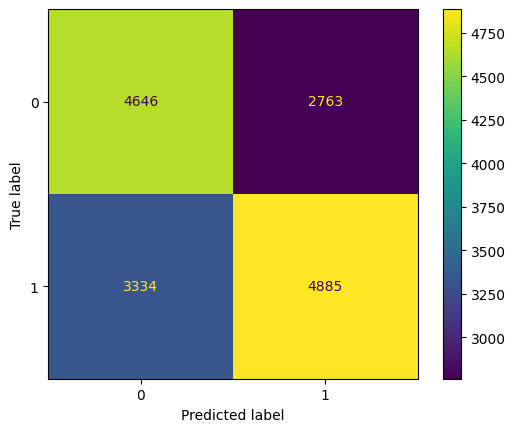

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluador de exactitud (accuracy)
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_label", predictionCol="prediction", metricName="accuracy"
)
accuracy = accuracy_evaluator.evaluate(predictions)
# Evaluador para precision, recall y F1 score
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_label", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_label", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_label", predictionCol="prediction", metricName="f1"
)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


'''________________________________ Matriz de confusión ________________________________'''
# Recopilar las etiquetas y predicciones como listas
y_true = predictions.select("rating_label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot()

Como vemos obtenemos resultados bastante malos. Con un accuracy de 0.609 tenemos un modelo que de forma general acierta unas 60,9% de las veces, es decir, es prácticamente aleatorio. La precisión es ligeramente mayor con un 61,16%, es decir, el modelo es un poco mejor realizando predicciones positivas. El recall nos indica como trabaja el modelo cuando recibe una clase positiva como input y, por último, el F1 que se encargar de medir un balance entre recall y precision.

En resumen, el predecir el rating de la película en función a sus actores, releases y duración no es un problema adecuado para clasificación. Necesatariamos aportar más variables como recaudación, tiempo de grabación, número de películas rodadas por el director, etc. Estas variables serían interesantes para intentar mejorar nuestro modelo de clasificación.

# Clustering

Como técnica de exploración de datos, primero usaré clustering. Concretamente utilizaré BisectingKMeans que es una variación del KMeans, pero funciona dividiendo de dos en dos clusteres el conjunto de datos. Así formaremos una estructura jerárquica de clusteres.

Como características se usarán "minute", "rating", "n_releases"

### Entrenamiento del modelo

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
# Configurar y ajustar el modelo BisectingKMeans
bkm = BisectingKMeans(featuresCol="MisVariablesClusteringEscaladas", predictionCol="prediction", k=5, seed=38)
bkm_model = bkm.fit(scaled_data_clustering)

# Transformar los datos para incluir los clusters
clustered_data = bkm_model.transform(scaled_data_clustering)

In [ ]:
# Mostrar los resultados
clustered_data.select("minute", "rating", "n_releases", "prediction").show(10)

# Mostrar el coste dentro del cluster
cost = bkm_model.computeCost(scaled_data_clustering)
print(f"Coste dentro del cluster: {cost}")

# Mostrar los centros de los clusters
print("Centros de los clusters:")
for center in bkm_model.clusterCenters():
    print(center)

+------+------+----------+----------+
|minute|rating|n_releases|prediction|
+------+------+----------+----------+
|   114|  3.86|        84|         4|
|   133|  4.56|       129|         4|
|   140|   4.3|        70|         4|
|   129|  4.09|       110|         4|
|   169|  4.35|       112|         4|
|   155|   3.9|        88|         4|
|   177|  3.98|        97|         4|
|   104|  4.16|        74|         4|
|   131|  3.99|        73|         4|
|   131|  3.43|        31|         3|
+------+------+----------+----------+
only showing top 10 rows



/usr/local/lib/python3.11/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


Coste dentro del cluster: 91151.16227738
Centros de los clusters:
[2.5421092  0.3856785  6.66189315]
[0.64345481 0.13830778 8.0355652 ]
[2.67844752 0.39711186 8.35380008]
[3.77973779 0.405739   7.79388945]
[3.25891236 5.17401167 8.18281324]


<ipython-input-24-62531173cc3b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = clustered_df['prediction'].map({i: plt.cm.get_cmap("tab10")(i) for i in range(6)})


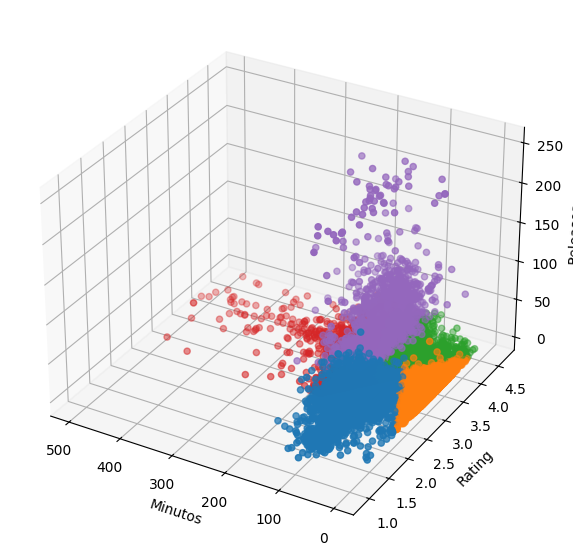

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Asumimos que 'clustered_data' tiene las columnas necesarias
# Convertimos los datos a un DataFrame de Pandas
clustered_df = clustered_data.select("minute", "rating","n_releases", "prediction").toPandas()

# Asignamos colores a los clusters
colors = clustered_df['prediction'].map({i: plt.cm.get_cmap("tab10")(i) for i in range(6)})

# Creamos la figura para la visualización 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Dibujamos los puntos
ax.scatter(clustered_df["minute"], clustered_df["rating"], clustered_df["n_releases"], c=colors)
#ax.invert_zaxis()
ax.invert_xaxis()
# Añadimos etiquetas a los ejes
ax.set_xlabel('Minutos')
ax.set_ylabel('Rating')
ax.set_zlabel('Releases')

# Mostramos la visualización
plt.show()


## Interpretación de resultados. Clustering

Tenemos un total de 5 clusters.

*   Cluster azul. Son películas con ratings por debajo de 3,5. Han tenido lanzamiento en menos de 50 países y la duración no parece ser muy determinante para las películas de este grupo.
*   Cluster amarillo. Este cluster tenemos películas con notas por encima de la media, un número de lanzamientos normal o bajo y, lo que más destaca, es que son de una corta duración (menos de 100 minutos).
*   Cluster verde. Aqui tenemos películas con duraciones ni muy cortas ni largas, un número de realeses normal, pero notas excelentes.
*   Cluster morado. Son películas que han sido lanzadas en gran parte del mundo, tienen una mayor duración que los anteriores clústeres (entre 2 y 3 horas) y suelen tener una calidad media (notas entre 3 y 4). Aunque tienen casos excepcionales con puntuaciones mayores que 4.
*   Cluster rojo. Este cluster recoge las películas de mayor duración, comprendiendo un rango de entre 3 horas y 8 horas. Estas películas cumplen un número de releases mucho menor que los demás clusters, esto tiene sentido pues una película con esa duración no es un producto demasiado comercial que esté pensado para llegar al máximo número de gente posible. Sin embargo, suelen estar por encima de 3,5 en calificaciones. Unas hipóstesis que puedo ofrecer de por qué suelen tener notas tan altas son las siguientes:
  1.   Supongo que la gente que va a ver estas películas suelen ser amantes del cine y podrían ir a verla con una predisposición a que les gustase, pues van a pasar más de 3 horas viendo una película. A parte, teniendo en cuenta el número de lanzamientos en países, son películas que no parecen muy accesibles para un gran público general.
  2.   Otra hipótesis es que los directores que se embarcan en proyectos tan arriesgados como estas películas extremadamente largas tienen mucha experiencia en el medio y no están haciendo un producto con el único fin de ganar dinero. En cambio, se estarían enfocando más en plasmar su visión artística en la películas, lo que mejoraría la calidad de las misma, sin importar que el gran público no se vaya a pensar en ver una película que dura 4 horas.

# Reglas de asociación

Considero que este problema no es del todo adecuado para las reglas de asociación. Sin embargo, un análisis que podríamos hacer y quizás obtener resultado interesantes sería para los géneros y actores.

## Géneros de películas

In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="collect_list(genre)", minSupport=0.001, minConfidence=0.6)
itemsets = fpGrowth.fit(data_genres)
# Mostramos los items frecuentes
itemsets.freqItemsets.show(truncate=False)

+--------------------------+------+
|items                     |freq  |
+--------------------------+------+
|[Action]                  |41695 |
|[Action, Comedy]          |7487  |
|[Action, Comedy, Drama]   |1108  |
|[Action, Romance]         |2476  |
|[Action, Romance, Drama]  |1015  |
|[Action, Horror]          |2737  |
|[Action, Animation]       |2706  |
|[Action, Thriller]        |7942  |
|[Action, Thriller, Horror]|727   |
|[Action, Thriller, Drama] |2199  |
|[Action, Drama]           |12105 |
|[Comedy]                  |140636|
|[Comedy, Documentary]     |2726  |
|[Comedy, Drama]           |30704 |
|[Mystery]                 |21394 |
|[Mystery, Action]         |1346  |
|[Mystery, TV Movie]       |1572  |
|[Mystery, Comedy]         |2426  |
|[Mystery, Romance]        |1183  |
|[Mystery, Horror]         |5089  |
+--------------------------+------+
only showing top 20 rows



Reglas de asociacion:

In [ ]:
# Mostramos las reglas de asociacion
itemsets.associationRules.show(truncate=False)

+---------------------+----------+------------------+-----------------+---------------------+
|antecedent           |consequent|confidence        |lift             |support              |
+---------------------+----------+------------------+-----------------+---------------------+
|[War, Romance]       |[Drama]   |0.8110047846889952|2.362769487638051|0.001002230628345388 |
|[History, Romance]   |[Drama]   |0.7587587587587588|2.210556679219605|0.00112048792962508  |
|[Adventure, Thriller]|[Action]  |0.6139444803098774|9.961096424734603|0.0014057836689623366|
+---------------------+----------+------------------+-----------------+---------------------+



## Interpretación de resultados. Reglas de asociación: géneros de películas

En los resultados obtenidos tenemos unos supports relativamente bajos puesto que hay muchas combinaciones entre los diferentes géneros que pueden tener las películas.

Primero, tenemos que una película que sea de guerra y romance, también será dramática con una confianza de 81,1% lo cual tiene mucho sentido. El drama también es consecuencia de una película sobre historia y romance, pero con una menor confianza. Por último, tenemos que adventura y thriller conllevará acción.

El lift cercano a 1 nos indica que la probabilidad de los items es baja y que la relación entre los géneros no es mucho mayor que la ocurrencia esperada por azar. Sin embargo, en el caso de Adventure, Thriller -> Action, el lift es significativamente alto (9.96), lo que muestra una fuerte relación entre estos géneros y sugiere que las películas de aventuras y thriller tienen una probabilidad mucho mayor de incluir acción en comparación con una elección aleatoria.

## Actores

In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="collect_list(name)", minSupport=0.00022, minConfidence=0.7)
itemsets = fpGrowth.fit(data_actores)

# Mostramos los items frecuentes
itemsets.freqItemsets.show(truncate=False)

+------------------------+----+
|items                   |freq|
+------------------------+----+
|[Pauline Carton]        |158 |
|[Donald Trump]          |244 |
|[Harvey Keitel]         |179 |
|[Vadivelu]              |226 |
|[Roberto Cañedo]        |177 |
|[James Finlayson]       |163 |
|[Larry Steers]          |266 |
|[Stellan Skarsgård]     |159 |
|[Akira Kamiya]          |142 |
|[Fred Tatasciore]       |189 |
|[Yasukaze Motomiya]     |230 |
|[Vladimír Kostovič]     |141 |
|[Rajinikanth]           |183 |
|[Kanji Tsuda]           |234 |
|[Anthony Wong Chau-Sang]|219 |
|[Peter Bogdanovich]     |166 |
|[Shinobu Araki]         |146 |
|[Takahiro Tamura]       |143 |
|[Theodore von Eltz]     |191 |
|[Rance Howard]          |165 |
+------------------------+----+
only showing top 20 rows



Reglas de asociacion:

In [ ]:
# Mostramos las reglas de asociacion
itemsets.associationRules.show(truncate=False)

+------------------------------------+----------------------+------------------+------------------+---------------------+
|antecedent                          |consequent            |confidence        |lift              |support              |
+------------------------------------+----------------------+------------------+------------------+---------------------+
|[Bebe Daniels, Harry 'Snub' Pollard]|[Harold Lloyd]        |0.9864864864864865|2744.4313655761025|2.3017427030026707E-4|
|[Harold Lloyd, Bebe Daniels]        |[Harry 'Snub' Pollard]|0.9733333333333334|1624.7033684210528|2.3017427030026707E-4|
|[Harold Lloyd, Harry 'Snub' Pollard]|[Bebe Daniels]        |0.9864864864864865|2618.1186249010516|2.3017427030026707E-4|
|[Larry Fine]                        |[Moe Howard]          |0.9874476987447699|2566.9674188901845|3.720625191155002E-4 |
|[James Hetfield]                    |[Kirk Hammett]        |0.8727272727272727|3618.1219251336897|2.27021198104373E-4  |
|[James Hetfield]       

## Interpretación de resultados. Reglas de asociación: actores

Para empezar, podemos obsevar como tenemos un support muy bajo (lo que conllevará un lift muy alto), esto es porque hay tantos actores diferentes que la probabilidad de que aparezcan unos en concreto es extremadamente baja. Por otra parte, sí vemos actores y parejas de actores que, en consecuencia, suelen ir acompañados por otros.

*   Primero, tenemos muchas relaciones entre Kirk Hammett, James Hetfield y Lars Ulrich. Una de ella es que si salen Kirk Hammett y James Hetfield con una confianza del 99% saldrá también Lars Ulrich. La explicación a estas relaciones es que son los miembros del grupo de música Metallica y en todas las películas que han salido actuan de ellos mismos. Es decir, necesitan al grupo completo para poder interpretar a Metallica obviamente, por ejemplo en Metallica - Cliff 'Em All y Metallica: Through the Never.

*   Segundo, tenemos a Bebe Daniels, Harri 'Snub' Pollard y Harold Lloyd. Estos fueron un trío de grandes cómicos del cine mudo, trabajaron juntos durante toda su carrera.

*   Por último, Moe Howard y Larry Fine son conocidos por formar parte de un trío cómico también. Observamos que la confianza de Larry Fine -> Moe Howard es ligeramente mayor que la de Moe Howard -> Larry Fine. Esto quiere decir que Moe Howard tiene menos películas en solitario sin Larry Fine. Lo que nos puede llamar la atención en este caso es que forman parte de un trío cómico, pero solo aparecen dos integrantes del trío en estas reglas de asociación. Esto sucede porque son los únicos dos integrantes del grupo que fueron fijos en el grupo, el tercer chiflado ha sido intepretado por Shemp Howard, Curly Howard, Joe Besser y Joe DeRita